<a href="https://colab.research.google.com/github/zp2226/E4511-2021-Zhanbo/blob/main/%E2%80%9Cpredict_drugclass_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NIH.AI Workshop: Predicting Drug Function Using Small-Molecule Structure Information
(this effort is part of the NCI-DOE Capability transfer project)

## Part 1: Generating Descriptor Data and Analysis
S.Ravichandran, Ph.D.
BIDS, FNLCR

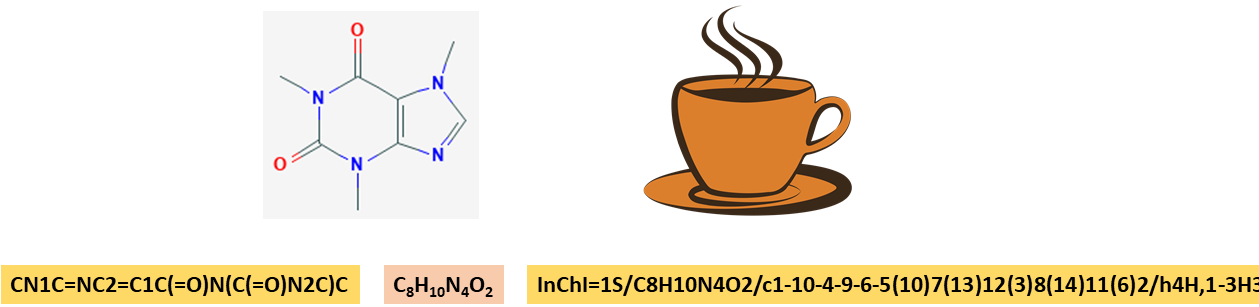

In [ ]:
from IPython.core.display import Image
Image(filename='Img/SMILES-Figures.png')

## Preliminary Information

Please [click on this link](Supp-files/preliminary-information.md) to view the preliminary information about the workshop. 

## Software-setup Information 

Please [click on this link](Supp-files/software-setup.md) here to see how to install the software needed this tutorial on your own system. 

## Molecular/Chemical information 

Please [click on this link](Supp-files/molecular-information.md) to read about the basics of molecular/chemical information (SMILES/SDF/PDB etc.). To visualize small molecules, we need atomic information. This can be obtained from different sources and formats (PubChem/DrugBank etc.; Formats: SMILES, PDB, Mol, sdf etc.). We will use SMILES strings for molecular information. There are many sources (check the last section, Supporting pages for details).

PubChem (https://pubchem.ncbi.nlm.nih.gov/) is a great resource for small molecule information. Please [click on this link](Supp-files/searching-pubchem.md) for a short demonstration on how to search for compounds in PubChem library. 

## Load the libraries

In [ ]:
import os, warnings
import numpy as np
import pandas as pd

from IPython.core.display import Image
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdDepictor, PandasTools
from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions 
from concurrent import futures

warnings.filterwarnings('ignore')
IPythonConsole.molSize = (450,200)

RDKit WARNING: [10:00:01] Enabling RDKit 2019.09.3 jupyter extensions


### Chemoinformatics library, rdkit, for small-molecule feature generation/analysis

Go to the following link, https://www.rdkit.org/, to learn about rdkit. If you have questions on how to use rdkit,  I recommend you to visit the detailed version of this 
workshop available from here, https://github.com/ravichas/SRWkshp1 

Please note that rdkit is a powerful chemoinformatics software. It can be used to read, compute (energy-minimization), visualize, create quality-figures and analyze both small molecule and protein sequences/structures. Please visit my github repo to learn about how to use rdkit for these
tasks, https://github.com/ravichas/SRWkshp1

### Let us display proteins/small-molecules before computing properties

PubChem is one of the good sources for small molecule related information. You can get SMILES strings for compounds from PubChem.

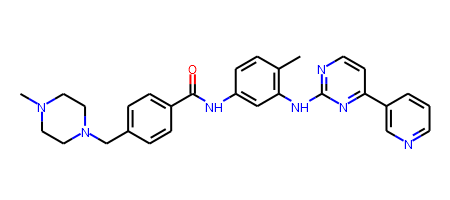

In [ ]:
imatinib = 'CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5'
imatinib_m = Chem.MolFromSmiles(imatinib)  #rdkit library
# generate 2D coordinates
rdDepictor.SetPreferCoordGen(True)
rdDepictor.Compute2DCoords(imatinib_m)
imatinib_m

In [ ]:
import py3Dmol

# The crystal structure of COVID-19 main protease in complex with an inhibitor N3
# The main protease (enzyme that catalyses/cuts proteins into smaller fragments) of coronavirus makes most of these cuts. The one shown here 
# (PDB entry 6lu7) is from the SARS-CoV-2 (or 2019-nCoV) coronavirus that is currently posing dangers in Wuhan

view = py3Dmol.view(query='pdb:7lyz')
view.setStyle({'cartoon':{'color':'spectrum'}})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Generating molecular properties

For this section, we will be using cdkit and Mordred (a molecular descriptor calculator) to generate molecular descriptors. Follow the links shown below for information on mordred calculator:

* https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y
* https://github.com/mordred-descriptor/mordred


## Molecular fingerprints

"Molecular fingerprints are a way of encoding the structure of a molecule. The most common type of fingerprint is a series of binary digits (bits) that represent the presence or absence of particular substructures in the molecule." (quote from OpenBabel documentation)

We will use Morgan Fringerprints. You can read about the details here, 
https://www.ncbi.nlm.nih.gov/pubmed/20426451 and here, https://www.daylight.com/dayhtml/doc/theory/theory.finger.html
 
Note most of the ideas are based on examples from cdkit manual. In a nutshell, each fragment in a molecule correspond to a bit. Two similar molecular fingerprints will have many common bits.

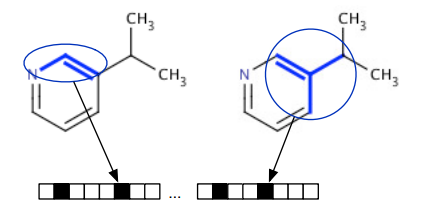

In [ ]:
Image(filename='Img/FPComp.PNG',width = 300, height = 300 )
# (Following figure is based on an an online presentation)

We are going to use fingerprint as features that define molecule. To explain the idea, let us use the two pain-killer drugs, paracetamol and pheacetin (withdrawn) as an example. First let us visualize, compute and analyze both the molecule and its fingerprint. 

In [ ]:
IPythonConsole.molSize = (450,200)

# fever reducer
paracetamol = 'CC(=O)NC1=CC=C(O)C=C1'
paracetamol_m = Chem.MolFromSmiles(paracetamol)
rdDepictor.Compute2DCoords(paracetamol_m)

# withdrawn fever reducer
phenacetin = 'CCOC1=CC=C(NC(C)=O)C=C1'
phenacetin_m = Chem.MolFromSmiles(phenacetin)
rdDepictor.Compute2DCoords(phenacetin_m)

# save the molecules as a list
mols = [paracetamol_m, phenacetin_m]

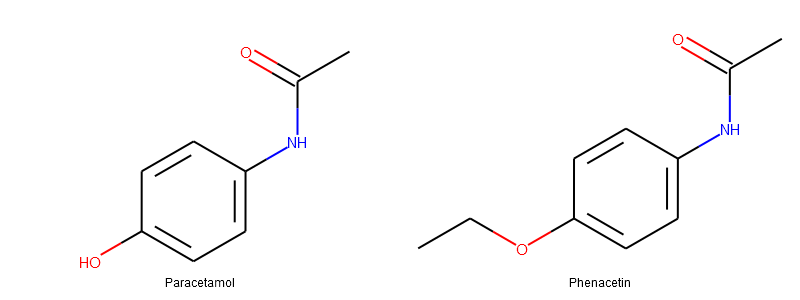

In [ ]:
Draw.MolsToGridImage(mols, subImgSize=(400, 300), molsPerRow = 2, legends = ['Paracetamol','Phenacetin'])

### We can convert fingerprint to bits and view them 

In [ ]:
# instantiate a dictionary 
bi1 = {}

fp1 = AllChem.GetMorganFingerprintAsBitVect(paracetamol_m, radius=2, bitInfo=bi1)
bits1 = fp1.ToBitString()
print(len(bits1))
bits1

2048


'000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000100000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [ ]:
print(len(list(fp1.GetOnBits())))

20


In [ ]:
print(list(fp1.GetOnBits()) )

[191, 245, 530, 650, 745, 807, 843, 849, 1017, 1057, 1077, 1152, 1313, 1380, 1602, 1750, 1778, 1816, 1873, 1917]


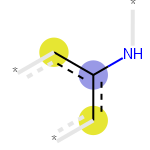

In [ ]:
# In its simplest form, the new code lets you display the atomic environment that sets a particular bit. Here we will look at bit 191:
Draw.DrawMorganBit(paracetamol_m,191,bi1)

Let us check whether Phencetin have the same fragment?

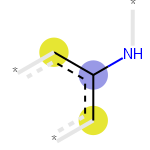

In [ ]:
bi2 = {}
fp2 = AllChem.GetMorganFingerprintAsBitVect(phenacetin_m, radius=2, bitInfo=bi2)
bits2 = fp2.ToBitString()

# In its simplest form, the new code lets you display the atomic environment that sets a particular bit. Here we will look at bit 191:
Draw.DrawMorganBit(phenacetin_m,191,bi2)

In [ ]:
# Let us find common bits based on Dr. Jan Jensen's tutorial
# you use set operation by saving the result not as a list 

common_bits = set( fp1.GetOnBits()) & set(fp2.GetOnBits())

combined_bits = set( fp1.GetOnBits()) | set(fp2.GetOnBits())

In [ ]:
print('Common_bits between Paracetamol and Phenacetin: ', common_bits,'\n')
print('Combined_bits between Paracetamol and Phenacetin: ', combined_bits)

Common_bits between Paracetamol and Phenacetin:  {1152, 1057, 1380, 807, 650, 843, 849, 530, 1873, 1077, 1750, 245, 1816, 1017, 1917, 191} 

Combined_bits between Paracetamol and Phenacetin:  {1152, 650, 530, 1816, 1057, 1313, 294, 807, 1452, 1077, 695, 191, 1602, 322, 69, 843, 718, 80, 849, 1873, 1750, 1238, 1380, 102, 745, 237, 1778, 245, 1017, 1917}


### 2D similarity 

$$ \textrm{Tanimoto} = \frac{N_{AB}} {N_A + N_B - N_{AB}} $$

For 3D functionality in the RDKit, refer to this link, http://rdkit.org/docs_temp/Cookbook.html. 
For today, we are going to stay with 2D fingerprints. 

In [ ]:
# this will give the common bits and the proportion will tell us the similarity
print('Raw Calculation :', len(common_bits)/len(combined_bits),'\n')

Raw Calculation : 0.5333333333333333 



In [ ]:
# import the library
from rdkit import DataStructs

# Tanimoto Similarity
print('Tanimoto Similarity: ', DataStructs.TanimotoSimilarity(fp1, fp2))

Tanimoto Similarity:  0.5333333333333333


## Mordred: For computing descriptors

We will be using a python package called  mordred for generating descriptors. Mordred Github Page: https://github.com/mordred-descriptor/mordred and click here to see the complete list of mordred descriptors,
https://mordred-descriptor.github.io/documentation/master/descriptors.html

In [ ]:
# code credit from mordred manual
from mordred import Calculator, descriptors
n_all = len(Calculator(descriptors, ignore_3D=False).descriptors)
n_2D = len(Calculator(descriptors, ignore_3D=True).descriptors)

print("2D:    {:5}\n3D:    {:5}\n------------\ntotal: {:5}".format(n_2D, n_all - n_2D, n_all))

2D:     1613
3D:      213
------------
total:  1826


### Compute molecular descriptors for a library of small-molecules

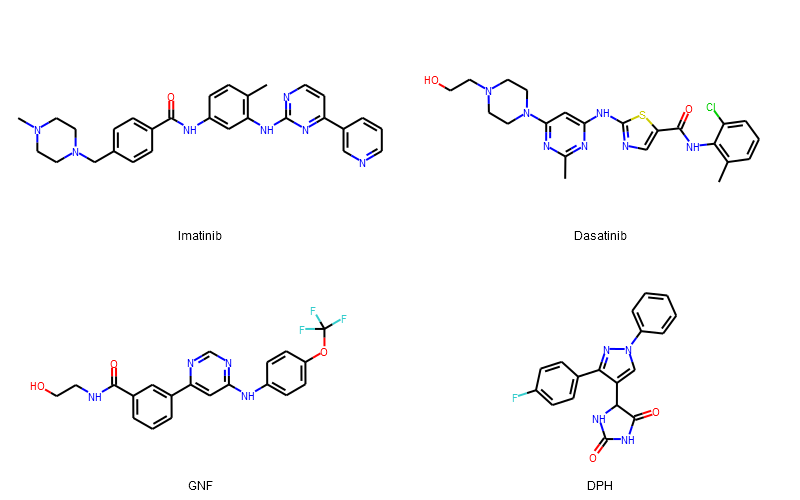

In [ ]:
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)

IPythonConsole.molSize = (800,800)
dasatinib = 'CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(=N3)C)N4CCN(CC4)CCO'
dasatinib_m = Chem.MolFromSmiles(dasatinib) 
rdDepictor.Compute2DCoords(dasatinib_m)

gnf5 = 'C1=CC(=CC(=C1)C(=O)NCCO)C2=CC(=NC=N2)NC3=CC=C(C=C3)OC(F)(F)F'
gnf5_m = Chem.MolFromSmiles(gnf5) 
rdDepictor.Compute2DCoords(gnf5_m)

dph = 'C1=CC=C(C=C1)N2C=C(C(=N2)C3=CC=C(C=C3)F)C4C(=O)NC(=O)N4'
dph_m = Chem.MolFromSmiles(dph)
rdDepictor.Compute2DCoords(dph_m)

molecules = [ imatinib_m, dasatinib_m, gnf5_m, dph_m ]
Draw.MolsToGridImage(molecules, molsPerRow = 2, subImgSize=(400, 250), legends = ['Imatinib','Dasatinib', 'GNF', 'DPH'])

**Please inspect the descriptor table before you use them in other calculations. Especially when you are generating all the descriptors, some of the columns may contain NA or Nan etc.**

In [ ]:
# calculate multiple molecule
mols = [Chem.MolFromSmiles(smi) for smi in [imatinib, dasatinib, gnf5, dph]]

# as pandas
df = calc.pandas(mols)

100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


In [ ]:
df

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,29.198227,19.516970,0,2,49.161634,2.372244,4.744487,49.161634,1.328693,4.541483,...,10.415502,73.587263,493.259009,7.253809,5324,56,194.0,224.0,9.972222,8.083333
1,25.731643,19.151718,0,1,42.312870,2.394767,4.762938,42.312870,1.282208,4.422390,...,10.323283,82.603238,487.155722,8.256877,3723,50,172.0,200.0,10.472222,7.277778
2,23.132682,16.941805,0,0,38.063201,2.370962,4.741923,38.063201,1.268773,4.312334,...,10.143881,65.313648,418.125275,8.896282,2918,42,152.0,171.0,10.090278,6.597222
3,19.924959,16.140292,0,0,32.867760,2.498596,4.828813,32.867760,1.314710,4.170130,...,10.150621,75.953704,336.102254,8.844796,1431,38,136.0,162.0,7.250000,5.388889


Please [visit](https://github.com/ravichas/SRWkshp1) GitHub repository to see additional examples and take-home exercises. 

## Part 2: Machine Learning for Predicing Drug Function Using Molecular Structures


Please check out a detailed version of this project from 
https://github.com/ravichas/SRWkshp1a

## Preliminary Information 

We will use the following manuscript as a testcase to explain the Machine-Learning concepts:

https://www.ncbi.nlm.nih.gov/pubmed/31518132

Overview of the work:
*  Chemical structures with MeSH derived therapeutic drug classes are the inputs. 
*  **Random Forest (RF)** Machine-Learning (ML) method and **Convolution Neural Network** was used for classification. For this workshop, we fill focus on RF for this workshop.


### Here is a schematic overview of the modeling procedure

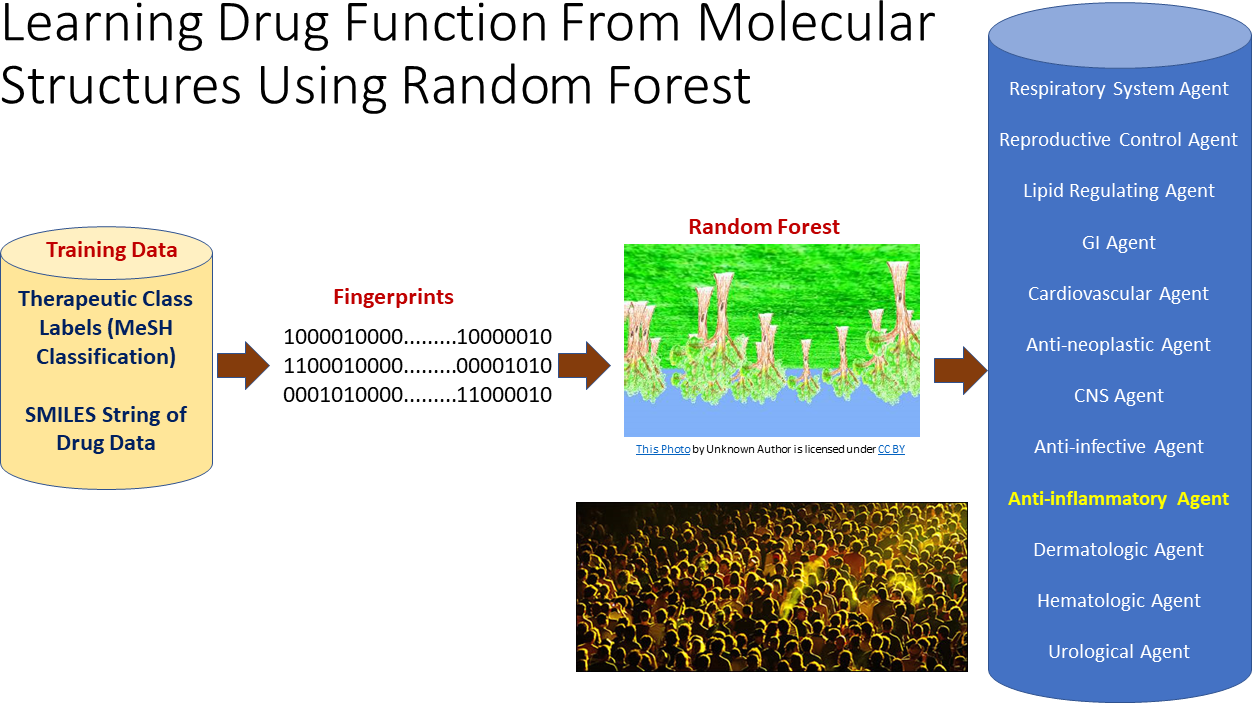

In [ ]:
from IPython.display import Image
Image('Img/DrugFunctionModeling-banner.png', width=900, height=900)

### To create drug function classifier models, we need two things:

* Chemical structures and their associated class labels
* Descriptors (Fingerprints)

## How to construct the SMILES drug dataset?
Input dataset can be constructed using PubChem (https://pubchem.ncbi.nlm.nih.gov/). 
Please note that Meyer et al paper provides a broad summary of input data construction. In this tutorial, I have given the details of the process. Please note due to database updates, search results might be different. Please [click here](Supp-files/pubchemdata.md) to see details on how to construct the dataset.

In [ ]:
## Preliminary library setup
import os, random, time, numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

## Load the data 

In [ ]:
import pandas as pd
df3  = pd.read_csv('Data/3cls_rmsaltol.csv')

# five class dataset
df5  = pd.read_csv('Data/5cls_rmsaltol.csv')

print("Here are few first/last 5 lines of the df3 data")
df3.iloc[0:6, [1,2]]

Here are few first/last 5 lines of the df3 data


,class,smiles
0,cns,O=C1CC=CO1
1,cns,CCC(=O)O[C@@]1(c2ccccc2)C[C@H](C)N(C)C[C@H]1C
2,cns,C=CCC(N)C(=O)O
3,cns,CC[C@@]12CCN(CC3CC3)[C@@H](C(=O)c3ccc(O)cc31)C2C
4,cns,c1csc(C2(N3CCCCC3)CCCCC2)c1
5,cns,O=C([O-])/C=C1\CCCc2ccccc2C1O


### Explore the dataset

In [ ]:
# All the data
print('Dimension of 3-class dataset', df3.shape)
print('Dimension of 5-class dataset', df5.shape)
# print('Dimension of 12-class dataset', df12.shape, '\n')

Dimension of 3-class dataset (3104, 3)
Dimension of 5-class dataset (5760, 3)


#### **Assign a specific dataset for modeling/analysis?**

For choosing a 3-class data, use 
``` df = df3 ```

For choosing a 5-class data, use ``` df = df5 ```

For now, we are going to use ```3-class data``` for modeling. 

In [ ]:
## Assign a dataset for analysis
df = df3

## Prepare the data for modeling

Encode target labels with value between 0 and n_classes-1.

In [ ]:
# convert the dataframe to numpy ndarray
x = df['smiles'].values
mols1 = [Chem.MolFromSmiles(smi) for smi in x]

In [ ]:
outcome = df['class'].values

le = preprocessing.LabelEncoder()
le.fit(outcome);

print('What labels are available in classes?:', list(le.classes_))
ys_fit = le.transform(outcome)

print('transformed outcome:  ', ys_fit)

What labels are available in classes?: ['antineoplastic', 'cardio', 'cns']
transformed outcome:   [2 2 2 ... 1 1 1]


From the above analysis, for a 3-class, df3a data, we see that 
```
0: Antineoplastic Agents (antineoplastic)
1: Cardiovascular Agents (cardio)
2: Central Nervous System Agents (cns)
```

## Data Analysis 

Let us answer the following questions: 

* How many Classes/Samples? 
* Is this a balanced outcome data?

In [ ]:
bin_count = np.bincount(ys_fit)
n_classes = len(bin_count)
print('How many classes? ',n_classes)
print('How many samples? ', len(ys_fit) )

print('How many from each class (raw numbers)? ', bin_count )
print('How many from each class (proportions)?: ', bin_count/(sum(bin_count)))

How many classes?  3
How many samples?  3104
How many from each class (raw numbers)?  [1177  788 1139]
How many from each class (proportions)?:  [0.37918814 0.25386598 0.36694588]


## Generate fingeprints: 

Read the following paper for details, https://www.ncbi.nlm.nih.gov/pubmed/20426451

In [ ]:
# Time to generate the Fingerprints: 8.323498249053955 seconds on core i7 laptop

time_start = time.time()

from rdkit.Chem import AllChem
fp1 = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in mols1]

# convert RDKit explicit vectors into NUMPY array
np_fps = np.asarray(fp1)

time_elapsed = time.time()-time_start
txt = 'Time to generate the Fingerprints: {} seconds '
print(txt.format(time_elapsed))

Time to generate the Fingerprints: 6.066907644271851 seconds 


In [ ]:
np_fps

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

### Let us display the first 11 columns of the top 20 molecular fingerprints

In [ ]:
print(np_fps[0:10,0:20])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]


## Getting ready to do modeling 

First, let us split the data

### How to keep track of train/test set indices?
To know the index of the train and test set compounds for testing, we can 
split on indices and then use them to split the compounds

In [ ]:
from sklearn.model_selection import train_test_split
seed = 123

all_indices=list(range(len(np_fps)))
len(all_indices)

train_indices, test_indices = train_test_split(all_indices,
                                              train_size=0.75,
                                              test_size=0.25,
                                              random_state=seed,
                                              stratify=ys_fit)

In [ ]:
train_X = np_fps[train_indices]
train_y = ys_fit[train_indices]

test_X = np_fps[test_indices]
test_y = ys_fit[test_indices]

train_y = list(train_y)
test_y = list(test_y)

In [ ]:
# This will not tell us what compound goes to test and what goes to train

# from sklearn.model_selection import train_test_split
# seed = 123

# train_X, test_X, train_y, test_y = train_test_split(np_fps, ys_fit, 
#                                                     train_size=0.75,
#                                                     test_size=0.25,
#                                                     random_state=seed,
#                                                     stratify = ys_fit)
# train_y = list(train_y)
# test_y = list(test_y)

### Explore the proportion of outcomes to answer questions about data imbalance

In [ ]:
train_X.shape
test_X.shape

(776, 1024)

In [ ]:
# Even outcome for this class
np.bincount(ys_fit)/len(ys_fit)

array([0.37918814, 0.25386598, 0.36694588])

## Supervised Learning using Random Forest
We will use Random-Forest based classifier for classification.
#### Why we are focussing on Random Forest?

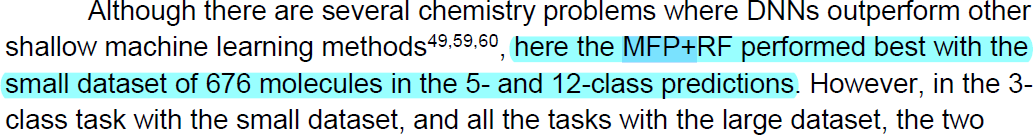

In [ ]:
Image('Img/PaperSummary1.png')

In [ ]:
# get a random forest classifiert with 100 trees
seed = 1123
rf = RandomForestClassifier(n_estimators=50, random_state=seed)

In [ ]:
from pprint import pprint
# View the parameters of the random forest
print('Parameters will be used for this model:\n')
pprint(rf.get_params())

Parameters will be used for this model:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1123,
 'verbose': 0,
 'warm_start': False}


In [ ]:
# train the random forest
rf.fit(train_X, train_y);

In [ ]:
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score

pred_y = rf.predict(test_X)
acc = metrics.accuracy_score(test_y, pred_y)
print("Test set accuracy: {:.2f}".format(acc))

balanced_acc_score = balanced_accuracy_score(test_y, pred_y)
print("Balanced set Accuracy Score: {:.2f}".format(balanced_acc_score))


Test set accuracy: 0.87
Balanced set Accuracy Score: 0.86


Normalized confusion matrix
[[0.901 0.014 0.085]
 [0.076 0.756 0.168]
 [0.081 0.011 0.909]]


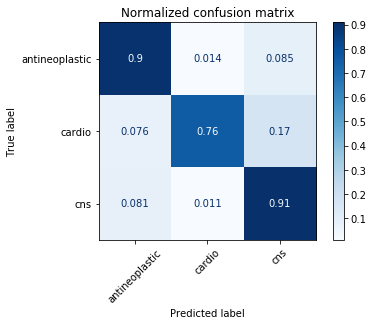

In [ ]:
# Plot non-normalized confusion matrix
# get a random forest classifiert with 100 trees
np.set_printoptions(precision=3)
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, test_X, test_y,
                                 display_labels=le.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    plt.xticks(rotation=45)
    
    print(title)
    print(disp.confusion_matrix)

plt.show()

## Inference
```
0: Antineoplastic Agents (antineoplastic)
1: Cardiovascular Agents (cardio)
2: Central Nervous System Agents (cns)
```

# How can we figure  you what compounds were predicted correctly? 

I am showing the code for the first 10 compounds

In [ ]:
print(rf.predict(test_X[0:10]))
print(test_y[0:10])
# pred_y = rf_best_grid.predict(test_X)

[0 2 2 0 2 2 0 1 0 0]
[0, 2, 2, 1, 2, 1, 0, 1, 0, 0]


In [ ]:
y_true = test_y[0:10]

In [ ]:
y_pred = rf.predict(test_X[0:10])

In [ ]:
# ind_s: indices for the same
# ind_d: indices for the different 

ind_s = y_true == y_pred

ind_d = y_true != y_pred


In [ ]:
indices = [i for i, x in enumerate(ind_d) if x]
print(indices)
[test_X[index] for index in indices]

# test_x[index]
# this is equivalent to 
# the following block

[3, 5]


[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]

In [ ]:
# for i, x in enumerate(indices):
#     print(i,x)
#     if(x): 
#         print(i)

## Questions 

* Can molecular fingerprints inherently capture molecular chemical features (Ex. Mol Wt., # of Hydrogen Bond Donors, # of Hydrogen Bond Acceptors)?
* Few drugs have similar fingerprints for CNS and Cardio class. What functional groups/fragments in the misclassified compounds are common? 
* What about 3D features?

### In the paper, https://pubmed.ncbi.nlm.nih.gov/31518132/, the Authors using the 5-label dataset model had identified drugs that were misclassified and upon inspection seems to have structures similar to that of the misclassified class.  

Pubchem CID, 121878, is classified as a cardiovascular drug, but in the Authors' 5-class model, misclassified as a respiratory system drug. A closely related compound called, cromokalim, is shown to be a  potassium channel modulating vasodilator known to act as a brochodilator

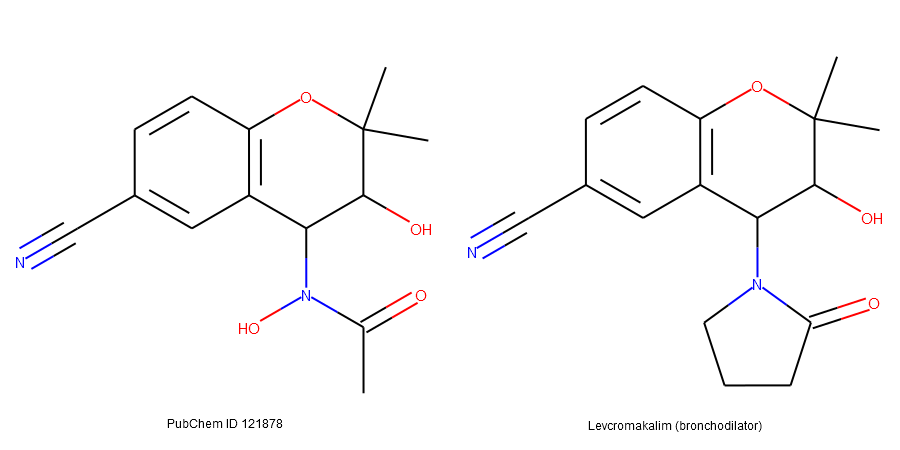

In [ ]:
# misclassified as a respiratory system drug 
cid_121878 = 'CC(=O)N(C1C(C(OC2=C1C=C(C=C2)C#N)(C)C)O)O'
cid_121878_m = Chem.MolFromSmiles(cid_121878)

rdDepictor.SetPreferCoordGen(True)
rdDepictor.Compute2DCoords(cid_121878_m)
# similarity with bronchodilator molecule 
cid_93504 = 'CC1(C(C(C2=C(O1)C=CC(=C2)C#N)N3CCCC3=O)O)C'
cid_93504_m = Chem.MolFromSmiles(cid_93504)
rdDepictor.Compute2DCoords(cid_93504_m)


molecules = [ cid_121878_m, cid_93504_m ]
Draw.MolsToGridImage(molecules, molsPerRow = 2, 
                     subImgSize=(450, 450), 
                     legends = ['PubChem ID 121878', 'Levcromakalim (bronchodilator)'])

## Final thoughts and questions to ponder!

- Can the model misclassification be due to lack of training and nothing to do with repurposing?
- What about bioactive conformations? 

## How can we improve the models?
There are several parametes (number of estimators, maximum features etc.) that could be assigned different values. 
These parameters are commonly referred to as Hyperparameters. Choosing the right combination is called HyperParameter 
Optimization (HPO).  

## Hyperparameter values (HP) and HP Optimization (HPO) 

For ScikitLearn implementation of RandomForest, we can adjust several HP values. Here is the complete list:

```
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1123,
 'verbose': 0,
 'warm_start': False}
 ```

Where do we start? The best option is to read the documentation, https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html. We have adopted the following choices based on the manuscript. 


| Parameter | Values   |
|----------|----------|
|  n_estimators  | 50, 250, 1000, 4000, 8000, 16000|
| max_features   | sqrt, log2 | 
| min_samples_leaf| 1, 10, 100, 1000 | 
| class_weight |  None, balanced_subsample, balanced| 


A HPO ```RandomizedSearchCV``` run was carried out in NIH HPC with the list shown in the table and found the following best combination. 

| Parameter | Values   |
|----------|----------|
|  n_estimators  | 8000 |
| max_features   | log2 | 
| min_samples_leaf| 1 | 
| class_weight |  balanced| 


**Acknowledgements:** Drs. George Zaki, Andrew Weisman, Randy Johnson, Hue Reardon, Anney Che and  Jaume Reventos for attending the mockup talks and suggestions. I would also like to thank FNLCR BIDS colleagues for reviewing the materials.